<a href="https://colab.research.google.com/github/pear2jam/notebooks/blob/main/fruits_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import patches

from torchvision import transforms as tt
import torchvision

from PIL import Image

import xml.etree.ElementTree as ET

import os
from google.colab import drive

Parsing dataset into tensor of images data and structure that represents bounding boxes

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
train_path = '/content/gdrive/MyDrive/Datasets/fruits_detection/train/train'
test_path = '/content/gdrive/MyDrive/Datasets/fruits_detection/test/test'

In [5]:
sorted(os.listdir(train_path))
train_pics_name = [i for i in sorted(os.listdir(train_path)) if i[-4:] == '.jpg']
train_xmls = [i for i in sorted(os.listdir(train_path)) if i[-4:] == '.xml']
test_pics_name = [i for i in sorted(os.listdir(test_path)) if i[-4:] == '.jpg']
test_xmls = [i for i in sorted(os.listdir(test_path)) if i[-4:] == '.xml']

In [6]:
class FruitsDataset(torch.utils.data.Dataset):
  def __init__(self, test = False):
    self.test = test
    self.classes = ['background', 'apple', 'orange', 'banana']
    self.transforms = tt.Compose([
      tt.ToTensor(),
      tt.Resize((300, 300))
    ])
    
  def __len__(self):
    return len(train_pics_name)

  def __getitem__(self, i):
    if not self.test:
      img = Image.open(os.path.join(train_path, train_pics_name[i]))
    else:
      img = Image.open(os.path.join(test_path, test_pics_name[i]))

    width = img.width
    height = img.height

    print(os.path.join(train_path, train_pics_name[i]))
    img = self.transforms(img)
    img = img[:3,:,:]

    y = {}
    y['boxes'] = list()
    y['labels'] = list()
    
    if not self.test:
      xml_path = os.path.join(train_path, train_xmls[i])
    else:
      xml_path = os.path.join(test_path, test_xmls[i])
    
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    n_objs = len(root) - 6

    for i in range(n_objs):
      y['labels'].append(self.classes.index(root[6 + i][0].text))
      x_min = int(root[6 + i][4][0].text)
      y_min = int(root[6 + i][4][1].text)
      x_max = int(root[6 + i][4][2].text)
      y_max = int(root[6 + i][4][3].text)

      #scaling coordiates to 300x300 image
      x_min = 300 * x_min / width
      y_min = 300 * y_min / height
      x_max = 300 * x_max / width
      y_max = 300 * y_max / height

      y['boxes'].append([x_min, y_min, x_max, y_max])
    y['labels'].append(0)
    y['labels'] = torch.as_tensor(y['labels'])
    #print(y['labels'])
    y['boxes'] = torch.as_tensor(y['boxes'])
    
    return (img, y)


In [7]:
from torch.utils.data import DataLoader
loader = DataLoader(FruitsDataset(), 16)

In [8]:
classes = ['background', 'apple', 'orange', 'banana']

/content/gdrive/MyDrive/Datasets/fruits_detection/train/train/mixed_15.jpg


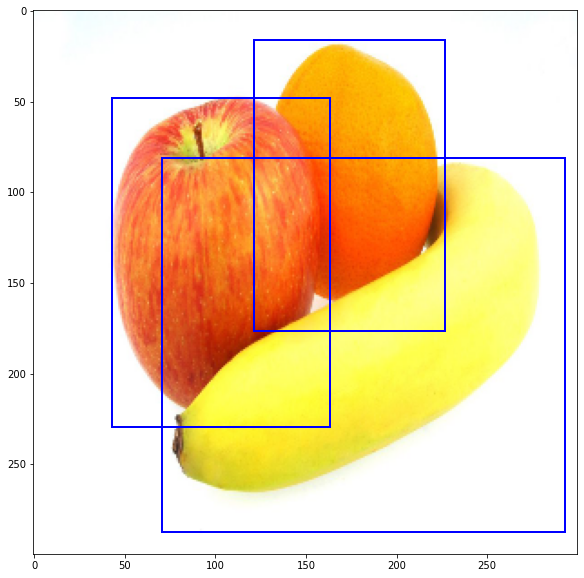

In [15]:
from IPython.core.pylabtools import figsize
i = 154
data = FruitsDataset()[i]
img = data[0]
boxes = data[1]['boxes']
labels = data[1]['labels'][:-1]

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

for i in range(len(labels)):
  w, h = boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1]
  rect = patches.Rectangle((boxes[i][0], boxes[i][1]), w, h, linewidth=2, facecolor='none', edgecolor='b')
  ax.add_patch(rect)
  ax.imshow(img.permute(1, 2, 0))

In [9]:
class VGG(torch.nn.Module):
  def __init__(self):
    super(VGG, self).__init__()

    self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

    self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
    self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
    self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
    self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
    self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
    self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

    self.conv6 = nn.Conv2d(512, 1024, 3, padding=6, dilation=6)

    self.conv7 = nn.Conv2d(1024, 1024, 1)

  def forward(self, X):
    X = self.conv1_1(X)
    X = self.conv1_2(X)
    X = self.pool1(X)

    X = self.conv2_1(X)
    X = self.conv2_2(X)
    X = self.pool2(X)

    X = self.conv3_1(X)
    X = self.conv3_2(X)
    X = self.conv3_3(X)
    X = self.pool3(X)

    X = self.conv4_1(X)
    X = self.conv4_2(X)
    X = self.conv4_3(X)

    conv4_3_res = X

    X = self.pool4(X)
    X = self.conv5_1(X)
    X = self.conv5_2(X)
    X = self.conv5_3(X)
    X = self.pool5(X)
    X = self.conv6(X)
    X = self.conv7(X) #conv7_res
    return X, conv4_3_res 

In [10]:
class Auxiliairy_layers(torch.nn.Module):
  def __init__(self):
    super(Auxiliairy_layers, self).__init__()

    self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0) 
    self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

    self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
    self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

    self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
    self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

    self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
    self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

  def forward(self, X):
    X = self.conv8_1(X)
    X = self.conv8_2(X)
    conv8_2_res = X
    X = self.conv9_1(X)
    X = self.conv9_2(X)
    conv9_2_res = X
    X = self.conv10_1(X)
    X = self.conv10_2(X)
    conv10_2_res = X
    X = self.conv11_1(X)
    X = self.conv11_2(X)
    return conv8_2_res, conv9_2_res, conv10_2_res, X

In [12]:
import time
st = time.time()
for i in range(10):
  x = VGG()(img.view(1, 3, 300, 300))[0].view(1, 1024, 19, 19)
  Auxiliairy_layers()(x)[0].shape
print((time.time()-st)/10)

1.2839342117309571


In [11]:
class Detection_boxes(torch.nn.Module):
  def __init__(self):
    super(Detection_boxes, self).__init__()
    
    self.conv4_3 = nn.Conv2d(512, 4*4, kernel_size = 3, padding = 1)
    self.conv7 = nn.Conv2d(1024, 6*4, kernel_size = 3, padding = 1)
    self.conv8_2 = nn.Conv2d(512, 6*4, kernel_size = 3, padding = 1)
    self.conv9_2 = nn.Conv2d(256, 6*4, kernel_size = 3, padding = 1)
    self.conv10_2 = nn.Conv2d(256, 4*4, kernel_size = 3, padding = 1)
    self.conv11_2 = nn.Conv2d(256, 4*4, kernel_size = 3, padding = 1)


  def forward(self, map4_3, map7, map8_2, map9_2, map10_2, map11_2):
    batch_size = map4_3.shape[0]

    pred4_3 = self.conv4_3(map4_3)
    pred7 = self.conv7(map7)
    pred8_2 = self.conv8_2(map8_2)
    pred9_2 = self.conv9_2(map9_2)
    pred10_2 = self.conv10_2(map10_2)
    pred11_2 = self.conv11_2(map11_2)

    pred4_3 = pred4_3.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    pred7 = pred7.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    pred8_2 = pred8_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    pred9_2 = pred9_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    pred10_2 = pred10_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    pred11_2 = pred11_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)

    boxes_pred = torch.cat([pred4_3, pred7, pred8_2, pred9_2, pred10_2, pred11_2], axis = 1)
    return boxes_pred
    


In [12]:
class Classes_regression(torch.nn.Module):
  def __init__(self, n_classes):
    super(Classes_regression, self).__init__()
    self.n_classes = n_classes

    self.conv4_3 = nn.Conv2d(512, 4*n_classes, kernel_size = 3, padding = 1)
    self.conv7 = nn.Conv2d(1024, 6*n_classes, kernel_size = 3, padding = 1)
    self.conv8_2 = nn.Conv2d(512, 6*n_classes, kernel_size = 3, padding = 1)
    self.conv9_2 = nn.Conv2d(256, 6*n_classes, kernel_size = 3, padding = 1)
    self.conv10_2 = nn.Conv2d(256, 4*n_classes, kernel_size = 3, padding = 1)
    self.conv11_2 = nn.Conv2d(256, 4*n_classes, kernel_size = 3, padding = 1)


  def forward(self, map4_3, map7, map8_2, map9_2, map10_2, map11_2):
    batch_size = map4_3.shape[0]
    n_classes = self.n_classes

    pred4_3 = self.conv4_3(map4_3)
    pred7 = self.conv7(map7)
    pred8_2 = self.conv8_2(map8_2)
    pred9_2 = self.conv9_2(map9_2)
    pred10_2 = self.conv10_2(map10_2)
    pred11_2 = self.conv11_2(map11_2)

    pred4_3 = pred4_3.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, n_classes)
    pred7 = pred7.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, n_classes)
    pred8_2 = pred8_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, n_classes)
    pred9_2 = pred9_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, n_classes)
    pred10_2 = pred10_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, n_classes)
    pred11_2 = pred11_2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, n_classes)

    classes_pred = torch.cat([pred4_3, pred7, pred8_2, pred9_2, pred10_2, pred11_2], axis = 1)
    return classes_pred
    


testing predictions

In [38]:
conv7_res, conv4_3_res = VGG()(img.view(1, 3, 300, 300))
conv8_2_res, conv9_2_res, conv10_2_res, conv11_2_res = Auxiliairy_layers()(conv7_res)

boxes_pred = Detection_boxes()(conv4_3_res, conv7_res, conv8_2_res, conv9_2_res, conv10_2_res, conv11_2_res)
classes_pred = Classes_regression(3)(conv4_3_res, conv7_res, conv8_2_res, conv9_2_res, conv10_2_res, conv11_2_res)

print(boxes_pred.shape)
print(classes_pred.shape)

torch.Size([1, 8732, 4])
torch.Size([1, 8732, 3])


In [17]:
def IoU(a, b):
  #x_min, y_min, x_max, y_max
  if a[2] <= b[0] or b[2] <= a[0] or a[3] <= b[1] or b[3] <= a[1]:
    return 0
  if b[0] > a[0]:
    interception_x = a[2] - b[0]
  else:
    interception_x = b[2] - a[0]
  
  if b[1] > a[1]:
    interception_y = a[3] - b[1]
  else:
    interception_y = b[3] - a[1]

  interception = interception_x * interception_y

  union = (a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - interception

  return interception / union


In [18]:
print(IoU(boxes[2], boxes[2]))
print(IoU(boxes[1], boxes[2]))
print(IoU(boxes[0], boxes[1]))

tensor(1.)
tensor(0.2553)
tensor(0.1618)


Now lets make matching

In [19]:
def matching(target, boxes_pred, classes_pred):
  min_overlap = 0.1
  IOU_list = []
  boxes = target[1]["boxes"]
  match_table = torch.IntTensor(len(boxes_pred[0]), 2) #assign each box their matched GT and label
  for prior in range(len(boxes_pred[0])):
    res_matching = np.zeros(len(boxes)) # IoUs vector of prior box with GT boxes

    for box in range(len(boxes)):
      res_matching[box] = IoU(boxes_pred[0][prior], target[1]["boxes"][box])
      IOU_list.append(res_matching[box])
    class_prediction = np.argmax(classes_pred.detach(), axis=2)
    if max(res_matching) < min_overlap:
      class_prediction = 0
    match_table[prior][1] = class_prediction 
  return match_table, IOU_list

In [20]:
table, stat = matching(FruitsDataset()[14], boxes_pred, classes_pred)

/content/gdrive/MyDrive/Datasets/fruits_detection/train/train/apple_22.jpg


In [21]:
np.unique(table[:,1])

array([0], dtype=int32)

In [62]:
nn.Sigmoid()(boxes_pred[0])

tensor([[0.5020, 0.4971, 0.4984, 0.4970],
        [0.5008, 0.5053, 0.4968, 0.4963],
        [0.4979, 0.4996, 0.5043, 0.5041],
        ...,
        [0.5025, 0.5060, 0.4987, 0.5025],
        [0.4970, 0.5035, 0.5003, 0.5029],
        [0.4973, 0.4979, 0.4966, 0.5043]])

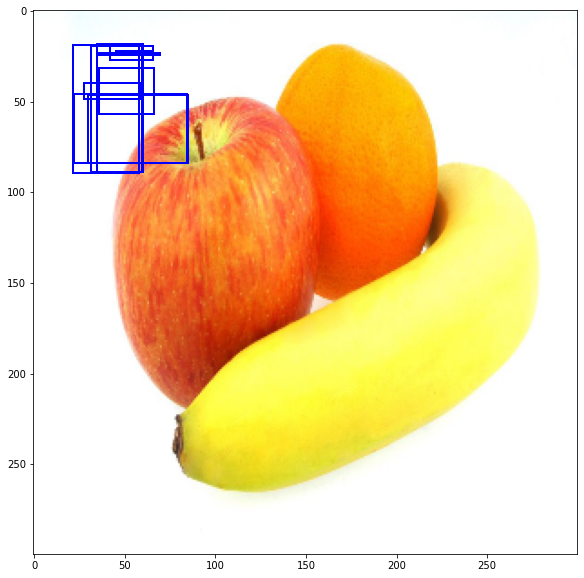

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
boxes = nn.Sigmoid()(boxes_pred[0]*100)*100
for i in range(10):
  w, h = boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1]
  rect = patches.Rectangle((boxes[i][0], boxes[i][1]), w, h, linewidth=2, facecolor='none', edgecolor='b')
  ax.add_patch(rect)
  ax.imshow(img.permute(1, 2, 0))

In [24]:
a = 1